This notebook prepares the ebutterfly data, not co-located with ebird), titled "SatButterfly-1", data from USA (starting year 2010), we  start with clustering the observations, creates polygons to extract the satellite images from planetary computer, filters images that are smaller than 128x128, creates the targets by aggregating the checklists, saves final csv for the hotspots

In [6]:
import pandas as pd 
import geopandas as gpd
import os
import numpy as np
import glob
from pathlib import Path    
from tqdm import tqdm
import json

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from shapely.geometry import Polygon, Point
from math import cos, radians

import random
import matplotlib.pyplot as plt
import rasterio as rio
import shutil
from pathlib import Path    

In [7]:
root_dir = "/data/SatButterfly"
dataset_tag = "SatButterfly_v1"

In [ ]:
def filter_locations(df): # (slow) takes around 30 mins
    """
    filter locations outside the continental US using the boundaries shape file cb_2018_us_nation_5m
    Parameters:
        df: Pandas dataframe with all observations
    Returns:
        df_clean: Pandas dataframe with filtered observations
    """
    gdf = gpd.read_file(os.path.join(root_dir, "cb_2018_us_nation_5m/cb_2018_us_nation_5m.shp"))
    indices = []
    for i, row in tqdm(df.iterrows()):
        if not gdf.geometry[0].contains(Point(row["decimalLongitude"], row["decimalLatitude"])):
            indices += [i]

    df_clean = df.drop(indices)
    return df_clean


def get_main_df(df_file_name):
    """
    return dataframe after location filtering
    Parameters:
        df_filename: filename of dataframe
    Returns:
        Pandas dataframe
    """
    butterfly_data_US = pd.read_csv(os.path.join(root_dir, df_file_name))
    # exclude observations in states
    states_to_exclude = ['Alaska', 'Hawaii']
    butterfly_data_US = butterfly_data_US[~butterfly_data_US['stateProvince'].isin(states_to_exclude)]
    
    # filter out based on USA geography
    butterfly_data_US = filter_locations(butterfly_data_US)

    return butterfly_data_US

butterfly_data_US = get_main_df("occ_usa.csv")
print(butterfly_data_US.head())

# saving intermediate files to avoid repeating steps when not necessary
butterfly_data_US.to_csv(os.path.join(root_dir, "occ_usa_geo_filtered.csv"))

- occ_usa.csv is extracted from ebutterfly raw observations (ebutterfly/Darwin/0177350-230224095556074/occurrence.txt, where country code in the US and starting the year 2010
- If the folder cb_2018_us_nation_5m does not exist, you can download from: https://www.census.gov/geographies/mapping-files/2018/geo/carto-boundary-file.html 

# Clustering ebutterfly data

In [ ]:
def cluster_ebutterfly_data(df):
    """
    clusters ebutterfly observations using DBSCAN based on haversine distance 
    Parameters:
        df: Pandas dataframe of ebutterfly observations
    Returns:
        df: Pandas dataframe with observations assigned to centriods
    """
    RADIUS_EARTH = 6356.7523 

    coordinates = df[['decimalLatitude', 'decimalLongitude']].values

    eps = 1/RADIUS_EARTH # Maximum distance between points to be considered part of the same cluster
    min_samples = 2  # Minimum number of points in a cluster (including the core point)

    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

    cluster_labels = db.labels_

    # Number of clusters in labels, ignoring noise (-1 is noise)
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    num_noise = len(set(cluster_labels)) - num_clusters
    print("Number of clusters:", num_clusters)
    print("Number of noise:", num_noise)

    clusters = pd.Series([coordinates[cluster_labels == n] for n in range(num_clusters)])

    def get_centermost_point(cluster):
        centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
        centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
        return tuple(centermost_point)

    centermost_points = clusters.map(get_centermost_point)
    center_lats, center_lons = zip(*centermost_points)

    # save final dataframe
    df["cluster_label"] = cluster_labels

    df = df[df["cluster_label"] != -1]

    cluster_labels = cluster_labels[np.where(cluster_labels != -1)]

    df["center_lat"] = [center_lats[cl] for cl in cluster_labels]
    df["center_lon"] = [center_lons[cl] for cl in cluster_labels]
    # assign hotspot ID to each cluster with prefix L
    df["hotspot_id"] = ["L" + str(cl) for cl in cluster_labels]

    df.reset_index(drop=True)

    return df

# read csv of filtered observations
butterfly_data_US = pd.read_csv(os.path.join(root_dir, "occ_usa_geo_filtered.csv"))
butterfly_data_US_clustered = cluster_ebutterfly_data(df=butterfly_data_US)

# save clustered butterfly dataset
butterfly_data_US_clustered.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_clustered.csv"))

# Generate satellite images

### 1. Create polygons for the lats, lons

In [ ]:
def generate_buffer_meter(data, radius, geometry='geometry', crs='epsg:4326', projected_crs='epsg:3857'): 
    """ Generates a buffer around the geometries in a geopandas DataFrame. 
    Parameters: 
        data (GeoDataFrame or DataFrame): The geopandas dataframe or a pandas dataframe that contains geometry data. 
        radius (float): The radius of the buffer in meters. 
        geometry (str, optional): The column in the dataframe that contains the geometry information. Defaults to 'geometry'. 
        crs (str, optional): The Coordinate Reference System of the input geometries. Defaults to 'epsg:4326'. 
        projected_crs (str, optional): The projected CRS to use for buffering. Defaults to 'epsg:3857'. 
    Returns: 
        data: GeoDataFrame: A new geopandas dataframe with the buffer applied to the geometry. 
    """ 
    data = gpd.GeoDataFrame(data) 
    data = data.to_crs(projected_crs)
    data[geometry] = data[geometry].buffer(radius, cap_style=3)
    data = data.to_crs(crs)
    return data


def generate_geometry(df):
    """ generates geometry using with radius 2500 around center hotspots
    Parameters: 
        df: Dataframe with ebutterfly clustered hotspots
    Returns:
        data_df: GeoDataFrame 
    """
    df = df.drop_duplicates().reset_index()

    geometry = [Point(xy) for xy in zip(df['center_lon'], df['center_lat'])]
    crs = {'init':'epsg:4326'}

    geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

    data_df = generate_buffer_meter(geo_df, 2500)
    return data_df


center_data_df = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_clustered.csv"), usecols=["hotspot_id", "center_lon", "center_lat"])
data_df = generate_geometry(center_data_df)

print(data_df.shape)
print(data_df.head())

data_df.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_center_polygons.csv"))

### 2. use the polygons file to extract satellite images from planetary compute, using the script (data_processing/ebutterfly_data_preparation/download_rasters_from_planetary_computer.py)

### 3. Filter satellite images and save final

In [ ]:
def filter_satellite_images(dst, image_folder="raw_images"):
    """ excludes satellite images that are less than 128x128
    Parameters:
        dst: folder name to save final images        
    """
    if not os.path.exists(dst):
        os.makedirs(dst)
    
    # src
    file_list = glob.glob(os.path.join(root_dir, dataset_tag, image_folder,  "*"))
    for i, file_path in enumerate(file_list):
        with rio.open(file_path) as f:
            r = f.read(3)
            g = f.read(2)
            b = f.read(1)
        composite = np.stack((r, g, b), axis=-1)
        if composite.shape[0] >= 128 and composite.shape[1] >= 128:
            shutil.copy(file_path, dst)

def get_final_hotspots(dst):
    """ returns list of final images after filtering 
    Parameters:
        dst: folder name to save final images
    Returns:
        List of final hotspots
    """
    final_hotspots = []
    file_list = glob.glob(os.path.join(dst, "*"))
    for i, file_path in enumerate(file_list):
        final_hotspots.append(str(Path(file_path).name.split(".")[0][1:]))
    
    print(len(final_hotspots))
    
    return final_hotspots

def explore_satellite_images(image_folder):
    """ visualizes satellite images
    Parameters:
        image_folder: image_folder
    Returns:
        
    """
    file_list = glob.glob(os.path.join(root_dir, dataset_tag, image_folder, "*"))

    # Select 8 random files from the list
    random_files = random.sample(file_list, 8)

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    for i, file_path in enumerate(random_files):
        with rio.open(file_path) as f:
            r = f.read(3)
            g = f.read(2)
            b = f.read(1)

        # Create a composite image from RGB channels
        composite = np.stack((r, g, b), axis=-1)
        print(composite.shape)

        # Clip and normalize the values
        normalized_composite = np.clip((composite / 10000), 0, 1)

        # Get the title from the file name
        title = file_path.split("/")[-1]

        # Plot the image in the corresponding subplot
        ax = axes[i // 4, i % 4]
        ax.imshow(normalized_composite)
        ax.set_title(title)
        ax.axis('off')
    # Adjust spacing and display the plot
    plt.tight_layout()
    plt.show()

explore_satellite_images(image_folder="images")

# exclude images of smaller sizes (less than 128x128)
dst = os.path.join(root_dir, dataset_tag, "images")

filter_satellite_images(dst=dst, image_folder="raw_images")
final_hotspots = get_final_hotspots(dst)

# exclude hotspots in butterfly dataframe that are not in final hotspots
butterfly_df = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_clustered.csv"))
butterfly_df = butterfly_df[butterfly_df['hotspot_id'].isin(final_hotspots)]
butterfly_df.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_final.csv"))

# Save Butterfly targets

In [ ]:
def group_clusters(butterfly_df):
    """ groups observations according to the center of clusters (hotspot_ID)
    Parameters:
        butterfly_df: Pandas DataFrame of butterfly observations
    Returns: 
        grouped_butterfly_data: Pandas DataFrame of butterfly observations after grouping
    """
    grouped_butterfly_data = butterfly_df.groupby(['hotspot_id'])
        
    group_sizes = grouped_butterfly_data.size()
    
    print(group_sizes)
    
    return grouped_butterfly_data

butterfly_df = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_final.csv"))
grouped_butterfly_data = group_clusters(butterfly_df)

In [ ]:
def save_species_list(df):
    """ save species list of all unique species, with their frequency in raw observations
    Parameters:
        df: Pandas DataFrame of butterfly observations
    Returns: 
        species_list: list of species names
    """
    species_df = df['species'].value_counts()
    
    species_df = species_df.reset_index()
    species_df.columns = ['species', 'frequency']
    
    species_df.to_csv(os.path.join(root_dir, dataset_tag, 'species/full_species_list.csv'), index=False)
    
    species_list = species_df["species"].values.tolist()
    print(len(species_list), species_list)
    
    return species_list

butterfly_df = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_final.csv"))
species_list = save_species_list(butterfly_df)

### Below is an intermediate step done only once: 

In [ ]:
# saving the list of species (common and union) between the hotspots here and ebird hotspots
species_list_v1 = pd.read_csv(os.path.join(root_dir, dataset_tag, 'species/full_species_list.csv'))
species_list_v2 = pd.read_csv(os.path.join(root_dir, "SatButterfly_v2", 'species/full_species_list.csv')) # species list of SatButterfly-v2

# choose butterfly species with occurrences >= 100, in both dataset versions
species_list_v1 = species_list_v1[species_list_v1["frequency"] >= 100]
species_list_v2 = species_list_v2[species_list_v2["frequency"] >= 100]

save_files = False
if save_files:
    # save species lists with occurrences >= 100, in both dataset versions
    species_list_v1.to_csv(os.path.join(root_dir, dataset_tag, 'species/species_list_occurrences_ge100.csv'), index=False)
    species_list_v2.to_csv(os.path.join(root_dir, "SatButterfly_v2", 'species/species_list_occurrences_ge100.csv'), index=False)

# get intersection and union of species 
final_species_list_intersect = np.intersect1d(species_list_v1['species'].values.tolist(), species_list_v2['species'].values.tolist())
final_species_list_union = np.union1d(species_list_v1['species'].values.tolist(), species_list_v2['species'].values.tolist())

print("Final species list: ", final_species_list_intersect)

if save_files:
    # save lists of species (intersection and union)
    with open(os.path.join(root_dir, "species/intersection_species_list_occurrences_ge100.txt"), 'w') as outfile:
        outfile.write('\n'.join(str(species_name) for species_name in final_species_list_intersect))
    with open(os.path.join(root_dir, "species/union_species_list_occurrences_ge100.txt"), 'w') as outfile:
        outfile.write('\n'.join(str(species_name) for species_name in final_species_list_union))

# save new species lists for SatButterfly_v1 with the intersection of species only
new_species_list = species_list_v1[species_list_v1['species'].isin(final_species_list_intersect)]
if save_files:
    new_species_list.to_csv(os.path.join(root_dir, dataset_tag, 'species/species_list_updated_172species.csv'), index=False)

# save new species lists for SatButterfly_v2 with the intersection of species only
new_species_list_2 = species_list_v2[species_list_v2['species'].isin(final_species_list_intersect)]
if save_files:
    new_species_list_2.to_csv(os.path.join(root_dir, "SatButterfly_v2", 'species/species_list_updated_172species.csv'), index=False)

### Compute ebutterfly target files

In [ ]:
def compute_target_files(grouped_butterfly_data, output_folder, species_list):
    """Creates targets by aggregating checklists, and saves json file per hotspot in output_folder
    Parameters:
        grouped_butterfly_data: Pandas DataFrame all butterfly observations, grouped per hotspot
        output_folder: folder name to save .json target files
        species_list: list of species to consider
    Returns:
    """
    for group_name, group_data in tqdm(grouped_butterfly_data):
        target = {}
        checklist_ = np.zeros(len(species_list))
        # dropping species that appear more than once in the same checklist
        new_df = group_data[['eventID', 'species']]
        new_df = new_df.drop_duplicates(['eventID', 'species'])

        for sp in new_df['species']:
            if sp in species_list:
                checklist_[species_list.index(sp)] += 1
        target['num_complete_checklists'] = len(group_data['eventID'].unique())
        # # NEW: to match SatBird scale
        # if target['num_complete_checklists'] < 5:
        #     continue
        checklist_ = checklist_ / target['num_complete_checklists']
        # if np.max(checklist_) > 1 :
        #     problamtic.append(group_name)
        
        hs_name = "B" + group_name[0]
        target['probs'] = checklist_.tolist()
        target['hotspot_id'] = hs_name

        with open(os.path.join(output_folder, hs_name + ".json"), 'w') as fp:
            json.dump(target, fp)

dst = os.path.join(root_dir, dataset_tag, "butterfly_targets_v1.2")
if not os.path.exists(dst):
    os.makedirs(dst)

final_species_list_intersect = open(os.path.join(root_dir, 'species/intersection_species_list_occurrences_ge100.txt')).read().split("\n")
compute_target_files(grouped_butterfly_data, dst, final_species_list_intersect)

### save final csv

In [ ]:
def save_final_csv(grouped_butterfly_data, output_filename='butterfly_hotspots.csv'):
    """ saves csv file with final hotspots with columns: hotspot_name, lon, lat, number_of_observations, number_of_unique_checklists, number_of_unique_species, env variables
    Parameters:
        grouped_butterfly_data: Pandas DataFrame all butterfly observations, grouped per hotspot
    """
    hotspot_ids = []
    lats, lons = [], []
    number_of_butterfly_obs = []
    number_of_unique_checklists = []
    number_of_different_species = []
    states = []

    for group_name, group_data in tqdm(grouped_butterfly_data):
        # if group_name in final_hotspots:
        # if len(group_data['eventID'].unique()) < 5:
        #     continue
        hotspot_ids.append("B" + group_name[0])
        lats.append(group_data['center_lat'].iloc[0])
        lons.append(group_data['center_lon'].iloc[0])
        states.append(group_data['stateProvince'].iloc[0])
        number_of_butterfly_obs.append(len(group_data['occurrenceID']))
        number_of_unique_checklists.append(len(group_data['eventID'].unique()))
        number_of_different_species.append(len(group_data['species'].unique()))

    final_data_frame = pd.DataFrame({'hotspot_id': hotspot_ids,
                                     'lat': lats,
                                     'lon': lons,
                                     'stateProvince': states,
                                     'ebutterfly_occurances': number_of_butterfly_obs,
                                     'num_checklists': number_of_unique_checklists,
                                     'num_species': number_of_different_species})

    print(final_data_frame.head())

    final_data_frame.to_csv(os.path.join(root_dir, dataset_tag, output_filename) , index=False)
    
save_final_csv(grouped_butterfly_data, 'butterfly_hotspots_all.csv')

## Extract environmental rasters

#### use the polygons file to extract environmental rasters, using the script (data_processing/environmental/get_env_var.py)
#### preferably on the cluster for the use of (geolifeclef-2022/rasters) data, using final csv file 'butterfly_hotspots_all.csv'

In [ ]:
dst = os.path.join(root_dir, dataset_tag, "environmental_data")
if not os.path.exists(dst):
    os.makedirs(dst)

### split data using DBSCAN (script: data_processing/utils/make_splits_by_distance.py), using the final csv (butterfly_hotspots_all.csv)

In [ ]:
def save_different_split_files(butterfly_data_with_split):
    """
    saves different csv files for each train/val/test split
    """
    grouped_butterfly_data = butterfly_data_with_split.groupby(['split'], as_index=False)

    for group_name, group_data in tqdm(grouped_butterfly_data):
        print(group_name)
        print(group_data["ebutterfly_occurances"].max())
        group_data.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_" + str(group_name[0]) + ".csv"))
        
butterfly_data_with_split = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_with_splits.csv"))

save_different_split_files(butterfly_data_with_split)

### Visualize map after splitting

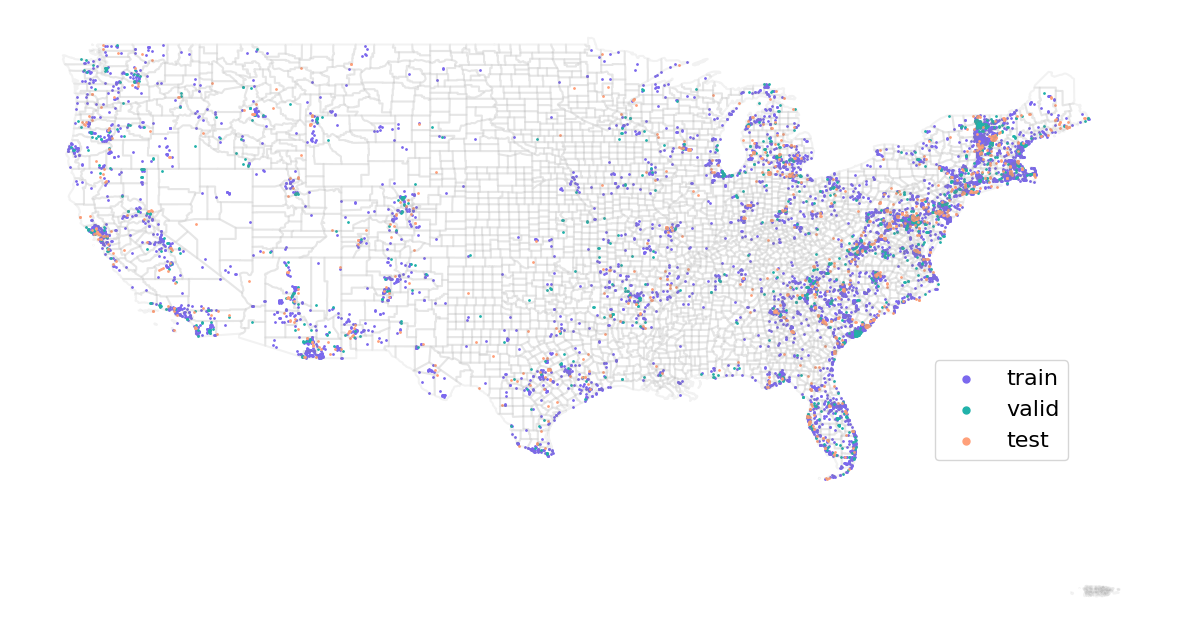

In [15]:
# plot final splits
import os
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))

import numpy as np
import pandas as pd
import json

import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point


def plot_final_splits(train_df, valid_df, test_df, save_path):
    geoDatav = gpd.read_file(
        'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson'
    )
    
    # Add geometry columns
    train_gdf = gpd.GeoDataFrame(train_df, geometry=[Point(xy) for xy in zip(train_df['lon'], train_df['lat'])])
    valid_gdf = gpd.GeoDataFrame(valid_df, geometry=[Point(xy) for xy in zip(valid_df['lon'], valid_df['lat'])])
    test_gdf  = gpd.GeoDataFrame(test_df,  geometry=[Point(xy) for xy in zip(test_df['lon'],  test_df['lat'])])

    fig, ax = plt.subplots(figsize=(15, 10))
    geoDatav[~geoDatav["STATE"].isin(["02", "15"])].boundary.plot(ax=ax, alpha=0.1, edgecolor="gray")
    train_gdf.plot(ax=ax, marker='o', color='mediumslateblue', markersize=1, label="train")
    valid_gdf.plot(ax=ax, marker='o', color='lightseagreen', markersize=1, label="valid")
    test_gdf.plot(ax=ax, marker='o', color='lightsalmon', markersize=1, label="test")

    plt.legend(fontsize=16, markerscale=5, loc='lower right', bbox_to_anchor=(0.92, 0.25))
    # plt.title("Butterfly Hotspots")
    ax.axis('off')
    plt.show()
    # Save figure
    fig.savefig(os.path.join(save_path, "satbutterfly_v1_data_dist.jpeg"), bbox_inches='tight')


path = os.path.join(root_dir, dataset_tag)
plot_final_splits(train_df=pd.read_csv(path + "/train_split.csv"), valid_df=pd.read_csv(path + "/valid_split.csv"), test_df=pd.read_csv(path + "/test_split.csv"), save_path=path)

Final files saved:
[('valid', 1147), ('test', 1145), ('train', 5316)]
- butterfly_hotspots_all.csv
- butterfly_hotspots_train.csv
- butterfly_hotspots_valid.csv
- butterfly_hotspots_test.csv
- species_list.csv
- butterfly_targets/
- environmental_data/
- images
- images_visual